In [64]:
import os
import sys
import torch
import random
import hashlib
import dataclasses
from abc import ABC
from tqdm import tqdm
from functools import partial
from typing import Optional, Any, Dict, List, Tuple, Callable

import numpy as np
import pandas as pd
import seaborn as sns
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [65]:
parent = os.path.dirname(os.getcwd())
if "notebooks" in parent:
    parent = os.path.dirname(parent)
sys.path.append(parent)

In [66]:
from common import example

# test run an import to ensure we can import
example.memoed_fib(25)

75025

# Baseline MNIST classifier (to be attacked)

In [67]:
mnist_train = datasets.MNIST('~/torch', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('~/torch', train=False, download=True, transform=transforms.ToTensor())

In [86]:
def accuracy(subset: DataLoader, model: nn.Module, *args, **kwargs) -> float:

    examples = 0
    correctly_labeled = 0
    
    for batch in subset:
        images, true_labels = batch
        pred_labels = model(images).argmax(dim=1)
        examples += len(pred_labels)
        correctly_labeled += torch.sum(true_labels == pred_labels)
    
    return int(correctly_labeled) / examples


@dataclasses.dataclass
class Experiment:
    
    seed: int
    epochs: int
    batch_size: int
    description: int
    loss: Callable
    optimizer: Callable
    
    metrics: Dict[str, Callable] = dataclasses.field(default_factory=dict)

In [87]:
class BaseCNNClassifier(nn.Module):

    def __init__(self):
        super(BaseCNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(2, 2), stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=(2, 2), stride=2)
        
        self.fc1 = nn.Linear(250, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)

        return x

In [104]:
def train(
    model: nn.Module,
    params: Experiment,
    train_dataset: Dataset,
    test_dataset: Dataset,
):
    training_set = DataLoader(mnist_train, batch_size=params.batch_size, shuffle=True) 
    test_set = DataLoader(mnist_train, batch_size=params.batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    loss_func = torch.nn.CrossEntropyLoss()
    loss_history = {
        "epoch_avg_train_loss": [],
        "epoch_avg_test_loss": [],
    }
    
    with tqdm(range(1, params.epochs + 1), desc="epoch training loss", leave=True) as epochs:
        for epoch in epochs:

            avg_train_loss = 0
            avg_test_loss = 0
            
            for i, batch in enumerate(training_set, 1):
                model.train()
                optimizer.zero_grad()
                images, true_labels = batch
                prob = model(images)
                loss = loss_func(prob, true_labels)
                loss.backward()
                optimizer.step()
                epochs.set_description(f"{epoch=}/{params.epochs}, batch={i}/{len(training_set)}, {loss=:.4f}(train)")

                avg_train_loss += loss.item() / len(training_set)

            for i, batch in enumerate(test_set, 1):
                model.eval()
                images, true_labels = batch
                prob = model(images)
                loss = loss_func(prob, true_labels)
                avg_test_loss += loss.item() / len(test_set)

            loss_history["epoch_avg_train_loss"].append(avg_train_loss)
            loss_history["epoch_avg_test_loss"].append(avg_test_loss)
    
    # evaluate
    metrics = { **{ metric: f(test_set, model) for metric, f in params.metrics.items() }, **loss_history }
    
    return model, metrics

In [110]:
model, metrics = train(
    model=BaseCNNClassifier(), 
    train_dataset=mnist_train, 
    test_dataset=mnist_test,
    params=Experiment(seed=32, description="baseline cnn", epochs=20, batch_size=32, metrics={"accuracy": accuracy})
)

epoch=20/20, batch=1875/1875, loss=1.8414(train): 100%|█| 20/20 [17:32<00:00, 52


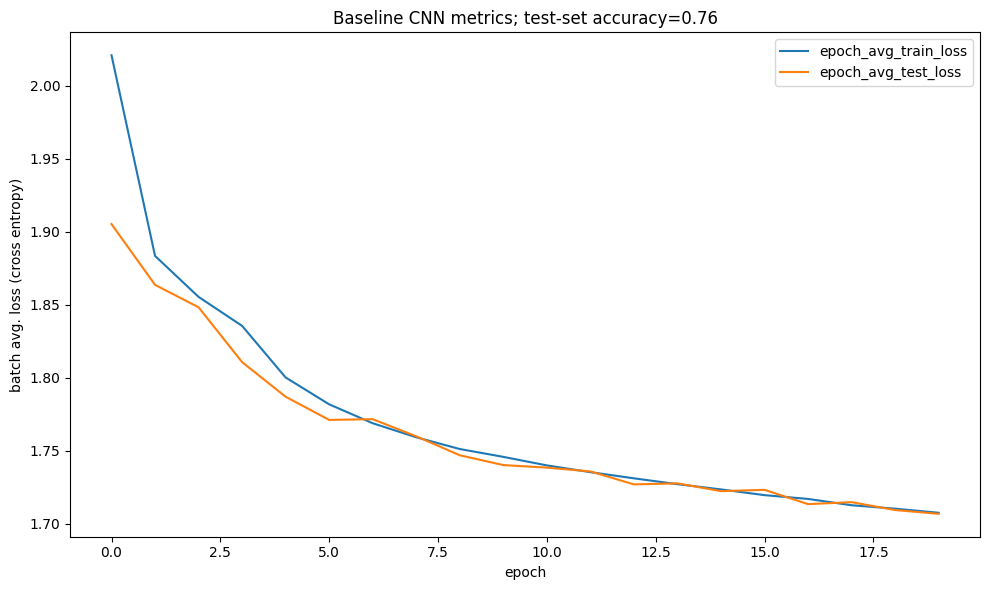

In [119]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 6))
ax.plot(metrics["epoch_avg_train_loss"], label="epoch_avg_train_loss")
ax.plot(metrics["epoch_avg_test_loss"], label="epoch_avg_test_loss")
plt.ylabel("batch avg. loss (cross entropy)")
plt.xlabel("epoch")
plt.title(f"Baseline CNN metrics; test-set accuracy={metrics['accuracy']:.2f}")
plt.legend()
plt.show()

# Noise

In [195]:
target = 2
image, true_label = mnist_test[10]
prediction_pre_noise = model(image.reshape(1, 1, 28, 28)).argmax(dim=1).item()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = torch.nn.CrossEntropyLoss()

noise = torch.rand(1, 28, 28) * .01
noise.requires_grad = True

for _ in tqdm(range(1, 2500 + 1), desc="injecting optimised noise"):
    distorted_image = torch.clamp(image + noise, 0, 1)
    pred = model(distorted_image.unsqueeze(0))
    loss = loss_func(pred, torch.Tensor([target]).long())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

prediction_post_noise = model(distorted_image.reshape(1, 1, 28, 28)).argmax(dim=1).item()

injecting optimised noise: 100%|███████████| 2500/2500 [00:05<00:00, 487.87it/s]


In [196]:
# visualise image /w label, noise, and image /w label post noise

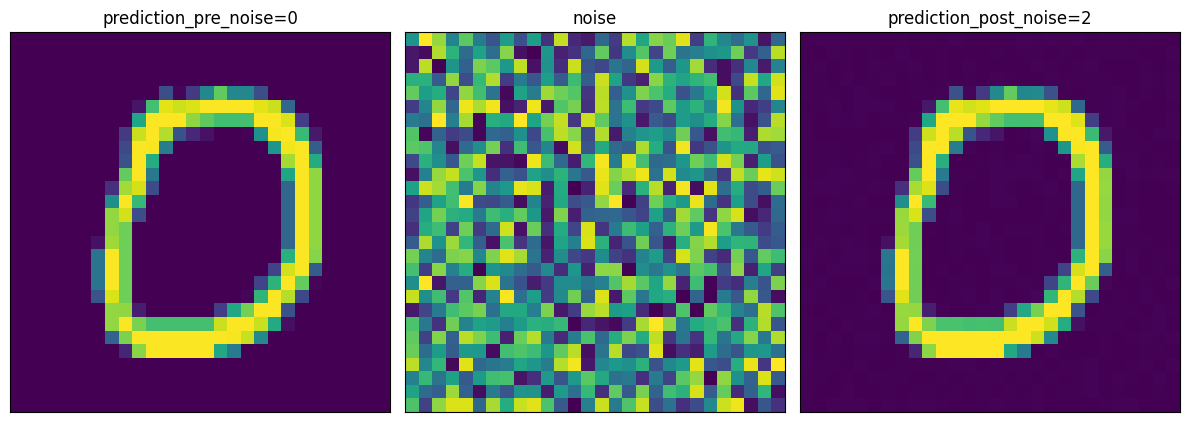

In [197]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 8))

ax1.imshow(image[0, :, :])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title(f"{prediction_pre_noise=}")

ax2.imshow(noise.detach()[0, :, :])
ax2.set_title(f"noise")
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(distorted_image.detach()[0, :, :])
ax3.set_title(f"{prediction_post_noise=}")
ax3.set_xticks([])
ax3.set_yticks([])
plt.show()